#  Transfer Learning

### Use pretrained weights VGG

In [32]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.utils as image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

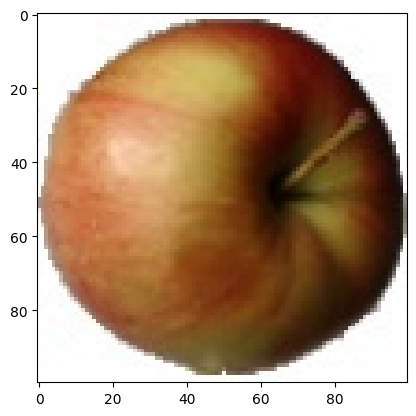

In [33]:
IMAGE_SIZE = [100,100]
epochs = 5
batch_size = 32

train_path = 'data/fruits-360/Training'
valid_path = 'data/fruits-360/Validation'

image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

folders = glob(train_path + '/*')

# look at an image 
plt.imshow(image.img_to_array(image.load_img(np.random.choice(image_files))).astype('uint8'))
plt.show()


In [34]:

# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3],
            weights='imagenet',
           include_top=False)

# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False
    
# our layers - we can add more if we want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# Create a model
model = Model(inputs = vgg.input, outputs = prediction)
model.summary()

2023-06-22 21:32:30.435283: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.00MiB (rounded to 9437184)requested by op AddV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-06-22 21:32:30.435358: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-06-22 21:32:30.435395: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 44, Chunks in use: 44. 11.0KiB allocated for chunks. 11.0KiB in use in bin. 1.9KiB client-requested in use in bin.
2023-06-22 21:32:30.435424: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 7, Chunks in use: 7. 4.2KiB allocated for chunks. 4.2KiB in use in bin. 3.5KiB client-requested in use in bin.
2023-06-22 21:32:30.435452: I tensorflow/tsl/framework/bfc_alloc

ResourceExhaustedError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:AddV2]

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
  metrics=['accuracy']
)

`ImageDataGenerator` is a class in the `keras.preprocessing.image` module that provides real-time data augmentation for image datasets during training. It allows you to generate batches of augmented image data on-the-fly, which can help improve the model's generalization and performance.

The `ImageDataGenerator` class offers a range of image augmentation techniques, such as rescaling, rotation, shifting, shearing, zooming, flipping, and more. These techniques can be applied to the training images to create new variations of the data, effectively increasing the diversity and size of the training set.

Here's an example of how to use `ImageDataGenerator` to perform image augmentation:


In [35]:
# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

In [36]:
# test generator to see how it works and some other useful things
# Load and augment images from a directory
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)


Found 9673 images belonging to 60 classes.
{'Apple Braeburn': 0, 'Apple Golden 1': 1, 'Apple Golden 2': 2, 'Apple Golden 3': 3, 'Apple Granny Smith': 4, 'Apple Red 1': 5, 'Apple Red 2': 6, 'Apple Red 3': 7, 'Apple Red Delicious': 8, 'Apple Red Yellow': 9, 'Apricot': 10, 'Avocado': 11, 'Avocado ripe': 12, 'Banana': 13, 'Banana Red': 14, 'Cactus fruit': 15, 'Carambula': 16, 'Cherry': 17, 'Clementine': 18, 'Cocos': 19, 'Dates': 20, 'Granadilla': 21, 'Grape Pink': 22, 'Grape White': 23, 'Grape White 2': 24, 'Grapefruit Pink': 25, 'Grapefruit White': 26, 'Guava': 27, 'Huckleberry': 28, 'Kaki': 29, 'Kiwi': 30, 'Kumquats': 31, 'Lemon': 32, 'Lemon Meyer': 33, 'Limes': 34, 'Litchi': 35, 'Mandarine': 36, 'Mango': 37, 'Maracuja': 38, 'Nectarine': 39, 'Orange': 40, 'Papaya': 41, 'Passion Fruit': 42, 'Peach': 43, 'Peach Flat': 44, 'Pear': 45, 'Pear Abate': 46, 'Pear Monster': 47, 'Pear Williams': 48, 'Pepino': 49, 'Pineapple': 50, 'Pitahaya Red': 51, 'Plum': 52, 'Pomegranate': 53, 'Quince': 54, 'Ra

In [37]:
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -108.91311 max: 151.061


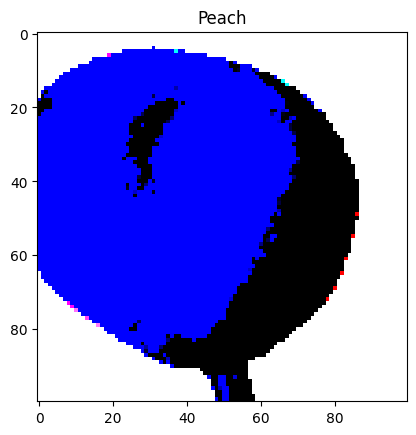

In [38]:
# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

In [39]:
# Load and augment images from a directory
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 28736 images belonging to 60 classes.
Found 9673 images belonging to 60 classes.


In [40]:
# Fit the model
r = model.fit(train_generator, 
              validation_data= valid_generator,
              epochs=epochs,
              steps_per_epoch= len(image_files)//batch_size,
              validation_steps=len(valid_image_files)//batch_size)

Epoch 1/5


2023-06-22 21:32:44.136665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-22 21:32:54.678546: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 78.12MiB (rounded to 81920000)requested by op model_2/block1_conv1/Relu
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-06-22 21:32:54.678645: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-06-22 21:32:54.678679: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 54, Chunks in use: 53. 13.5KiB allocated for c

ResourceExhaustedError: Graph execution error:

Detected at node 'model_2/block1_conv1/Relu' defined at (most recent call last):
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_31797/2180152918.py", line 2, in <module>
      r = model.fit(train_generator,
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 321, in call
      return self.activation(outputs)
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/keras/activations.py", line 317, in relu
      return backend.relu(
    File "/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/keras/backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'model_2/block1_conv1/Relu'
OOM when allocating tensor with shape[32,64,100,100] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_2/block1_conv1/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_3716]